## 模型选择、欠拟合和过拟合

In [7]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## 使用以下三阶多项式来生成训练数据和测试数据的标签

$$
y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!} + \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, 0.1^2)
$$

伽玛函数($\Gamma$函数):
$$
 \Gamma(n) = (n-1)!
$$

In [40]:
# 特征为20
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
# 前几位是真是的参数，后续的是噪音项
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
# poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
# np.arange(max_degree) => [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,17, 18, 19]
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

for i in range(max_degree):
    # 伽马函数，此处用于求阶乘
    poly_features[:,i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
# 均值为0，方差为0.1的正态分布
labels += np.random.normal(scale=0.1, size=labels.shape)

## 看一下前两个样本

In [41]:
# 将numpy nparray 转为张量
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]


(tensor([[1.0359],
         [0.3932]]),
 tensor([[1.0000e+00, 1.0359e+00, 5.3658e-01, 1.8529e-01, 4.7986e-02, 9.9421e-03,
          1.7166e-03, 2.5403e-04, 3.2895e-05, 3.7864e-06, 3.9224e-07, 3.6940e-08,
          3.1889e-09, 2.5412e-10, 1.8804e-11, 1.2986e-12, 8.4080e-14, 5.1236e-15,
          2.9487e-16, 1.6077e-17],
         [1.0000e+00, 3.9317e-01, 7.7291e-02, 1.0130e-02, 9.9566e-04, 7.8293e-05,
          5.1304e-06, 2.8816e-07, 1.4162e-08, 6.1868e-10, 2.4325e-11, 8.6943e-13,
          2.8486e-14, 8.6153e-16, 2.4195e-17, 6.3418e-19, 1.5584e-20, 3.6042e-22,
          7.8725e-24, 1.6291e-25]]),
 tensor([5.5498, 5.0976]))

## 实现一个函数来评估模型在给定数据集上的损失

In [42]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

## 定义训练函数

In [34]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    # 平方误差函数
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=True))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        # d2l.train_ch3(net, train_iter, loss, trainer)
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1 ) % 20 == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight: ', net[0].weight.data.numpy())

## 三阶多项式函数拟合（正态）

weight:  [[ 2.4442017  1.2038742 -3.413075   5.5668797]]


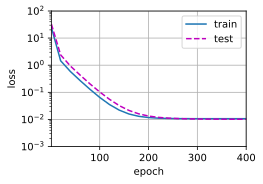

In [35]:
# 使用前4列
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

## 线性函数拟合（欠拟合） 

weight:  [[1.27249   4.2274747]]


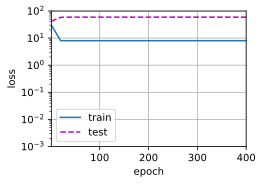

In [37]:
# 只给两列数据
train(poly_features[:n_train, :2], poly_features[:n_train, :2], labels[:n_train], labels[n_train:])

## 高阶多项式函数拟合（过拟合）

weight:  [[ 2.5729454   1.3162405  -3.1198802   5.0028825  -0.6305919   1.5305876
   0.0685027   0.24687828 -0.212509    0.18733753 -0.19997902 -0.08988865
  -0.16275407  0.15674882 -0.04255596  0.11199623  0.13169682  0.12557137
  -0.21255678  0.18367466]]


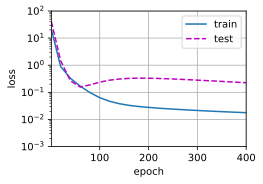

In [43]:
train(poly_features[:n_train,:], poly_features[n_train:, :], labels[:n_train], labels[n_train:])